# Results on test dataset

In [1]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer
from datasets import load_dataset, load_metric
import numpy as np

# Load the test dataset
dataset = load_dataset("conll2003")
test_dataset = dataset["test"]

# Load the tokenizer and model
model_checkpoint = 'muhammadahmad2622/bert-finetuned-ner'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)


In [2]:
# Define the function for tokenizing and aligning labels (assuming your dataset structure)
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    
    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize and align the labels for the test dataset
test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

# Define the data collator
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Predict on the test dataset
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [p for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [l for l in label if l != -100]
    for label in labels
]

# Load the "seqeval" metric
metric = load_metric("seqeval")
label_list = test_dataset.features["ner_tags"].feature.names
true_labels = [[label_list[l] for l in label] for label in true_labels]
true_predictions = [[label_list[p] for p in prediction] for prediction in true_predictions]

results = metric.compute(predictions=true_predictions, references=true_labels)
print(results)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_21824\1281264491.py:50: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
C:\Users\Ahmed\anaconda3\lib\site-packages\datasets\load.py:752: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'LOC': {'precision': 0.9265837773830669, 'recall': 0.9382494004796164, 'f1': 0.9323801012809056, 'number': 1668}, 'MISC': {'precision': 0.7891891891891892, 'recall': 0.8319088319088319, 'f1': 0.8099861303744801, 'number': 702}, 'ORG': {'precision': 0.8982142857142857, 'recall': 0.9084888621312462, 'f1': 0.9033223585752769, 'number': 1661}, 'PER': {'precision': 0.9670602858918583, 'recall': 0.9622758194186766, 'f1': 0.9646621202727836, 'number': 1617}, 'overall_precision': 0.9118572927597062, 'overall_recall': 0.9231586402266289, 'overall_f1': 0.917473165581559, 'overall_accuracy': 0.9834607515882416}


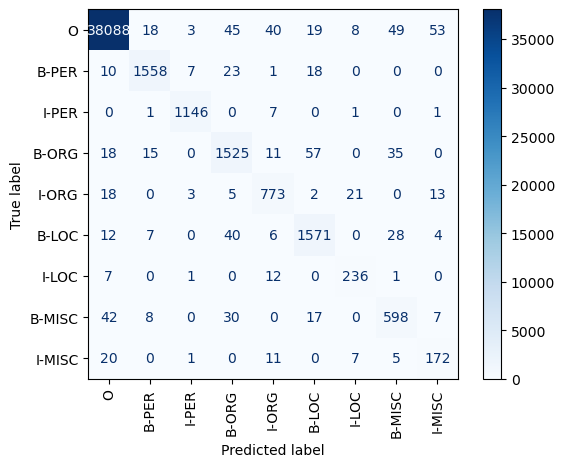

In [3]:
# For confusion matrix, you might need to flatten the lists and use sklearn or another library
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

flattened_labels = [label for sublist in true_labels for label in sublist]
flattened_predictions = [prediction for sublist in true_predictions for prediction in sublist]

conf_matrix = confusion_matrix(flattened_labels, flattened_predictions, labels=label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_list)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()
